In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as jsp
from minigp.gp import *
from minigp.kernel import DeepKernelParameters, DeepKernel
from minigp.utils import *

In [2]:
def warp(x: jnp.ndarray) -> jnp.ndarray:
    """Warping function that maps [0, 24pi] to [0, 12pi], with non-linear squeezing."""
    # Define boundaries
    segment1 = 2 * jnp.pi
    segment2 = 10 * jnp.pi
    max_x = 12 * jnp.pi

    # Define corresponding warped boundaries
    warped_segment1 = 16 * jnp.pi
    warped_segment2 = 18 * jnp.pi
    max_warped = 34 * jnp.pi

    # Apply piecewise transformation
    warped_x = jnp.where(x <= segment1,
                         x * (warped_segment1 / segment1),  # Squeeze the first segment
                         jnp.where(x <= segment2,
                                   (x - segment1) * ((warped_segment2 - warped_segment1) / (segment2 - segment1)) + warped_segment1,  # Middle segment mostly unchanged
                                   (x - segment2) * ((max_warped - warped_segment2) / (max_x - segment2)) + warped_segment2  # Squeeze the last segment
                         ))
    return warped_x

def warped_sine(x: jnp.ndarray) -> jnp.ndarray:
    """Compute sine of the warped input."""
    warped_x = warp(x)
    return jnp.sin(warped_x)


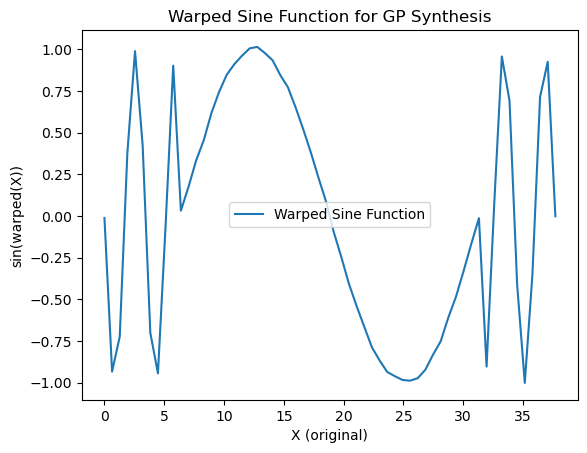

In [3]:
X_train = jnp.linspace(0, 12 * jnp.pi, 60).reshape(-1, 1)
y_train = warped_sine(X_train.flatten()) + 0.01 * random.normal(jax.random.PRNGKey(0), (60,))

X_np = np.array(X_train)
y_np = np.array(y_train)

# Plot the warped sine function
plt.plot(X_np, y_np, label="Warped Sine Function")
plt.title("Warped Sine Function for GP Synthesis")
plt.xlabel("X (original)")
plt.ylabel("sin(warped(X))")
plt.legend()
plt.show()

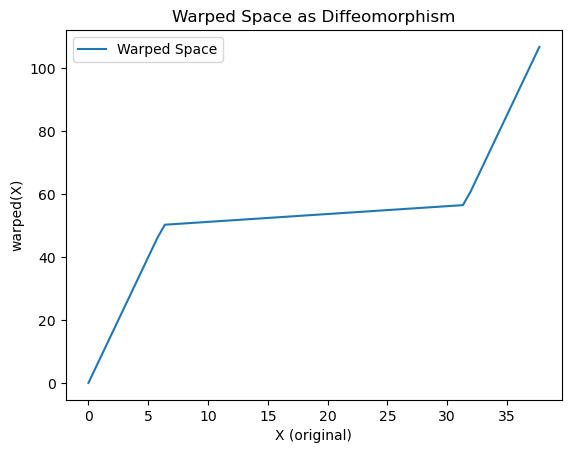

In [4]:
plt.plot(X_np, np.array(warp(X_train)), label="Warped Space")
plt.title("Warped Space as Diffeomorphism")
plt.xlabel("X (original)")
plt.ylabel("warped(X)")
plt.legend()
plt.show()

In [5]:
block = [1,15,15]
layer_dims = block * 20 + [1]

key = jax.random.PRNGKey(0)

net = ResNetNN(layer_dims, key)
kernel = DeepKernel(net_fn=net, layer_dims=layer_dims)
kernel_params = kernel.init_params(key)

gp = GaussianProcess()
state, gp_params = gp.init_state_with_params(kernel, kernel_params, X_train, y_train)

In [6]:
optimized_kernel_params, optimized_gp_params = optimize_mle_nn(gp, state, kernel_params, gp_params, num_iters= 500, learning_rate = 0.008)
state, gp_params = gp.fit(state, optimized_kernel_params, optimized_gp_params)

Iteration 10, Loss: 63.2821
Iteration 20, Loss: 63.2413
Iteration 30, Loss: 63.0915
Iteration 40, Loss: 63.0277
Iteration 50, Loss: 63.0087
Iteration 60, Loss: 62.9934
Iteration 70, Loss: 62.9804
Iteration 80, Loss: 62.9707
Iteration 90, Loss: 62.9617
Iteration 100, Loss: 62.9549
Iteration 110, Loss: 62.9486
Iteration 120, Loss: 62.9446
Iteration 130, Loss: 62.9398
Iteration 140, Loss: 62.9344
Iteration 150, Loss: 62.9288
Iteration 160, Loss: 62.9232
Iteration 170, Loss: 62.9162
Iteration 180, Loss: 62.9072
Iteration 190, Loss: 62.8968
Iteration 200, Loss: 62.8846
Iteration 210, Loss: 62.8711
Iteration 220, Loss: 62.8546
Iteration 230, Loss: 62.8358
Iteration 240, Loss: 62.8146
Iteration 250, Loss: 62.7853
Iteration 260, Loss: 62.7553
Iteration 270, Loss: 62.7125
Iteration 280, Loss: 62.6895
Iteration 290, Loss: 62.6553
Iteration 300, Loss: 62.6078
Iteration 310, Loss: 62.5402
Iteration 320, Loss: 62.4802
Iteration 330, Loss: 62.4566
Iteration 340, Loss: 62.4091
Iteration 350, Loss: 62

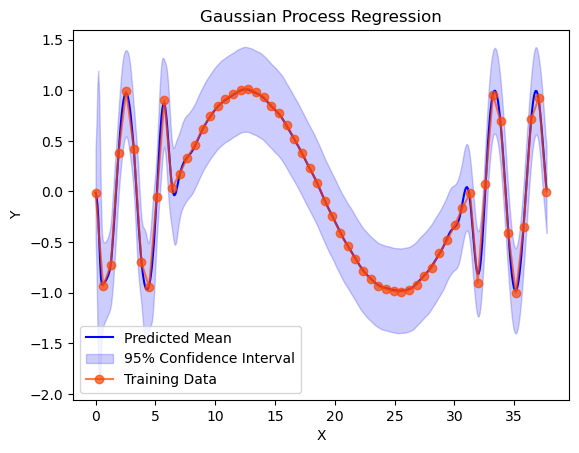

In [7]:
X_test = jnp.linspace(0, 12 * jnp.pi, 500).reshape(-1, 1)
y_true = warped_sine(X_test.flatten())
mu_s, cov_s = gp.predict(state, optimized_kernel_params, optimized_gp_params, X_test)
std_s = jnp.sqrt(cov_s)

plot_process(X_train, y_train, X_test, mu_s, std_s)

[0.    0.114 0.15  0.165 0.171 0.178 0.184 0.194 0.21  0.232 0.254 0.275
 0.295 0.315 0.335 0.353 0.37  0.384 0.393 0.401 0.409 0.416 0.422 0.429
 0.435 0.44  0.446 0.451 0.455 0.46  0.464 0.469 0.473 0.476 0.48  0.484
 0.487 0.49  0.493 0.496 0.499 0.502 0.505 0.507 0.507 0.507 0.508 0.508
 0.508 0.509 0.509 0.509 0.51  0.51  0.51  0.51  0.511 0.511 0.511 0.511
 0.511 0.512 0.512 0.512 0.512 0.512 0.513 0.513 0.513 0.513 0.513 0.513
 0.514 0.514 0.514 0.514 0.514 0.514 0.514 0.514 0.515 0.515 0.515 0.515
 0.515 0.515 0.515 0.515 0.516 0.516 0.516 0.516 0.517 0.518 0.52  0.521
 0.523 0.525 0.526 0.528 0.529 0.531 0.532 0.534 0.535 0.537 0.538 0.539
 0.541 0.542 0.543 0.545 0.546 0.547 0.549 0.55  0.551 0.552 0.553 0.555
 0.556 0.557 0.558 0.559 0.56  0.561 0.562 0.563 0.564 0.566 0.567 0.568
 0.569 0.57  0.571 0.572 0.572 0.573 0.574 0.575 0.576 0.577 0.578 0.579
 0.58  0.581 0.582 0.582 0.583 0.584 0.585 0.586 0.586 0.587 0.588 0.589
 0.59  0.59  0.591 0.592 0.593 0.593 0.594 0.595 0.

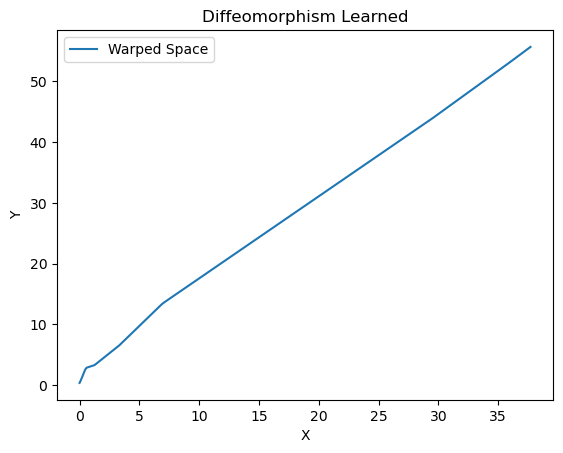

In [8]:
plot_diffeomorphism_1D(X_test, kernel, optimized_kernel_params)

In [9]:
print(optimized_kernel_params)

DeepKernelParameters(sigma=Array(0.975, dtype=float32), nn_params={'W1': Array([[-0.074, -0.283,  0.04 ,  0.073,  0.144,  0.25 , -0.113,  0.037,
        -0.26 ,  0.11 ,  0.096,  0.147,  0.222, -0.154, -0.167]],      dtype=float32), 'W10': Array([[-0.002,  0.159,  0.196,  0.111,  0.043, -0.139, -0.077,  0.142,
         0.237,  0.153,  0.105,  0.118, -0.257, -0.219, -0.014]],      dtype=float32), 'W11': Array([[ 0.044,  0.128, -0.081, -0.078,  0.101,  0.178,  0.183, -0.025,
         0.039,  0.019, -0.164, -0.004,  0.01 , -0.04 ,  0.173],
       [ 0.111,  0.12 ,  0.048, -0.204, -0.124, -0.075, -0.079, -0.025,
        -0.002,  0.014,  0.034, -0.164, -0.122,  0.001, -0.092],
       [ 0.083,  0.027,  0.087, -0.316, -0.067,  0.075, -0.035, -0.034,
         0.043, -0.238,  0.138, -0.213,  0.006, -0.081, -0.058],
       [ 0.048, -0.058, -0.102, -0.074,  0.019, -0.032, -0.037,  0.011,
         0.054,  0.117, -0.291, -0.074, -0.089, -0.093, -0.058],
       [ 0.022, -0.195, -0.126, -0.336, -0.183,